In [249]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from io import BytesIO
import glob
import random
import requests

In [250]:
# Load Teams API data
teams_json = requests.get('https://site.api.espn.com/apis/site/v2/sports/football/nfl/teams').json()
teams = teams_json['sports'][0]['leagues'][0]['teams']

team_dict = []

for t in teams:
    team_dict.append({
        'id': t['team']['id'],
        'color': t['team']['color'],
        'alternateColor': t['team']['color'],
        'logo': t['team']['logos'][0]['href'],
        'abbreviation': t['team']['abbreviation'],
        'displayName': t['team']['displayName'],
        'location': t['team']['location'],
        'name': t['team']['name'],
        'nickname': t['team']['nickname'],
        'shortDisplayName': t['team']['shortDisplayName'],
    })

# Create Teams DataFrame using team abbreviations as index
team_df = pd.DataFrame(team_dict).set_index('abbreviation')
team_df

,id,color,alternateColor,logo,displayName,location,name,nickname,shortDisplayName
abbreviation,,,,,,,,,
ARI,22,a4113e,a4113e,https://a.espncdn.com/i/teamlogos/nfl/500/ari.png,Arizona Cardinals,Arizona,Cardinals,Cardinals,Cardinals
ATL,1,a71930,a71930,https://a.espncdn.com/i/teamlogos/nfl/500/atl.png,Atlanta Falcons,Atlanta,Falcons,Falcons,Falcons
BAL,33,29126f,29126f,https://a.espncdn.com/i/teamlogos/nfl/500/bal.png,Baltimore Ravens,Baltimore,Ravens,Ravens,Ravens
BUF,2,00338d,00338d,https://a.espncdn.com/i/teamlogos/nfl/500/buf.png,Buffalo Bills,Buffalo,Bills,Bills,Bills
CAR,29,0085ca,0085ca,https://a.espncdn.com/i/teamlogos/nfl/500/car.png,Carolina Panthers,Carolina,Panthers,Panthers,Panthers
CHI,3,0b1c3a,0b1c3a,https://a.espncdn.com/i/teamlogos/nfl/500/chi.png,Chicago Bears,Chicago,Bears,Bears,Bears
CIN,4,fb4f14,fb4f14,https://a.espncdn.com/i/teamlogos/nfl/500/cin.png,Cincinnati Bengals,Cincinnati,Bengals,Bengals,Bengals
CLE,5,472a08,472a08,https://a.espncdn.com/i/teamlogos/nfl/500/cle.png,Cleveland Browns,Cleveland,Browns,Browns,Browns
DAL,6,002a5c,002a5c,https://a.espncdn.com/i/teamlogos/nfl/500/dal.png,Dallas Cowboys,Dallas,Cowboys,Cowboys,Cowboys


In [251]:
# load 2024 games DF
games_df = pd.concat(map(pd.read_csv, glob.glob(f'data/nfl-big-data-bowl-2024/games.csv')))

games_df['homeTeamAbbr'] = games_df['homeTeamAbbr'].replace('LA', 'LAR').replace('WAS', 'WSH')
games_df['visitorTeamAbbr'] = games_df['visitorTeamAbbr'].replace('LA', 'LAR').replace('WAS', 'WSH')

games_df.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,09/08/2022,20:20:00,LAR,BUF,10,31
1,2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,09/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,09/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,09/11/2022,13:00:00,CIN,PIT,20,23


In [252]:
len(games_df['homeTeamAbbr'].unique())

32

In [253]:
# plays_df = pd.concat(map(pd.read_csv, glob.glob(f'data/nfl-big-data-bowl-*/plays.csv')))
# Import 2024 Plays DF
plays_df = pd.read_csv('data/nfl-big-data-bowl-2024/plays.csv')

plays_df['possessionTeam'] = plays_df['possessionTeam'].replace('LA', 'LAR').replace('WAS', 'WSH')
plays_df['defensiveTeam'] = plays_df['defensiveTeam'].replace('LA', 'LAR').replace('WAS', 'WSH')

plays_df.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,NaN,NaN,NaN,NaN
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,...,0.756661,0.243339,-0.037409,0.037409,1.312855,1.133666,NaN,NaN,NaN,NaN
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,...,0.620552,0.379448,-0.002451,0.002451,1.641006,-0.043580,NaN,NaN,NaN,NaN
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,...,0.836290,0.163710,0.001053,-0.001053,3.686428,-0.167903,NaN,NaN,NaN,NaN


In [254]:
plays_df.dtypes

gameId                                int64
playId                                int64
ballCarrierId                         int64
ballCarrierDisplayName               object
playDescription                      object
quarter                               int64
down                                  int64
yardsToGo                             int64
possessionTeam                       object
defensiveTeam                        object
yardlineSide                         object
yardlineNumber                        int64
gameClock                            object
preSnapHomeScore                      int64
preSnapVisitorScore                   int64
passResult                           object
passLength                          float64
penaltyYards                        float64
prePenaltyPlayResult                  int64
playResult                            int64
playNullifiedByPenalty               object
absoluteYardlineNumber                int64
offenseFormation                

In [255]:
len(plays_df)

12486

In [256]:
# Concatenate GameId and PlayID to create a unique ID for plays across games
# The dataset re-uses playid values across games
plays_df['play_uuid'] = plays_df['gameId'].astype(str) + '.' + plays_df['playId'].astype(str)
plays_df['play_uuid'].head()

0    2022100908.3537
1    2022091103.3126
2    2022091111.1148
3    2022100212.2007
4    2022091900.1372
Name: play_uuid, dtype: object

In [257]:
# (GITHUB COLAB AI) 
# prompt: load all CSV files with a name like "tracking_week_" into a tracking_df dataframe
import glob
tracking_df = pd.concat(map(pd.read_csv, glob.glob(f'data/nfl-big-data-bowl-2024/*week*.csv')))

In [258]:
# generate same Play-UUID for frame lookup
tracking_df['play_uuid'] = tracking_df['gameId'].astype(str) + '.' + tracking_df['playId'].astype(str)
tracking_df['play_uuid'].head()

0    2022100600.90
1    2022100600.90
2    2022100600.90
3    2022100600.90
4    2022100600.90
Name: play_uuid, dtype: object

In [259]:
# List event types from Tracking table
tracking_df['event'].unique()

array([nan, 'ball_snap', 'handoff', 'first_contact', 'tackle',
       'pass_arrived', 'pass_outcome_caught', 'out_of_bounds', 'run',
       'fumble', 'man_in_motion', 'autoevent_passforward', 'shift',
       'play_action', 'touchdown', 'pass_forward', 'snap_direct',
       'line_set', 'qb_slide', 'autoevent_ballsnap',
       'autoevent_passinterrupted', 'pass_shovel', 'lateral',
       'penalty_flag', 'qb_sack', 'fumble_offense_recovered', 'safety',
       'pass_outcome_touchdown', 'fumble_defense_recovered',
       'run_pass_option', 'penalty_accepted'], dtype=object)

In [260]:
tracking_df.loc[(tracking_df['event'] == 'touchdown')]

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
109659,2022100900,736,29851.0,Aaron Rodgers,19,2022-10-09 10:03:49.400000,12.0,GB,left,18.470000,30.38,1.48,0.64,0.14,345.02,329.03,touchdown,2022100900.736
109682,2022100900,736,30842.0,Marcedes Lewis,19,2022-10-09 10:03:49.400000,89.0,GB,left,8.280000,28.78,2.70,1.99,0.28,75.72,308.87,touchdown,2022100900.736
109705,2022100900,736,37139.0,Randall Cobb,19,2022-10-09 10:03:49.400000,18.0,GB,left,8.880000,27.56,2.05,2.63,0.22,3.46,303.28,touchdown,2022100900.736
109728,2022100900,736,40057.0,David Bakhtiari,19,2022-10-09 10:03:49.400000,69.0,GB,left,12.190000,30.68,1.62,0.91,0.17,306.69,297.32,touchdown,2022100900.736
109751,2022100900,736,41336.0,Justin Ellis,19,2022-10-09 10:03:49.400000,71.0,NYG,left,13.850000,31.02,0.30,1.16,0.04,343.33,56.27,touchdown,2022100900.736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1396719,2022103100,3304,54533.0,Martin Emerson,24,2022-10-31 22:42:52.500000,23.0,CLE,right,100.770000,27.58,4.03,1.29,0.41,43.14,52.77,touchdown,2022103100.3304
1396747,2022103100,3304,54543.0,Alex Wright,24,2022-10-31 22:42:52.500000,94.0,CLE,right,77.720000,29.40,2.61,1.14,0.27,76.13,80.73,touchdown,2022103100.3304
1396775,2022103100,3304,54601.0,Cordell Volson,24,2022-10-31 22:42:52.500000,67.0,CIN,right,75.050000,36.56,3.87,1.49,0.40,80.31,73.03,touchdown,2022103100.3304
1396803,2022103100,3304,54688.0,Isaiah Thomas,24,2022-10-31 22:42:52.500000,58.0,CLE,right,72.990000,32.88,1.61,0.62,0.17,81.04,79.88,touchdown,2022103100.3304


In [261]:
# Normalize abbreviations to match ESPN team list
tracking_df['club'].unique()

array(['IND', 'DEN', 'football', 'GB', 'NYG', 'BUF', 'PIT', 'LAC', 'CLE',
       'HOU', 'JAX', 'CHI', 'MIN', 'NE', 'DET', 'SEA', 'NO', 'NYJ', 'MIA',
       'TB', 'ATL', 'TEN', 'WAS', 'SF', 'CAR', 'PHI', 'ARI', 'LA', 'DAL',
       'BAL', 'CIN', 'LV', 'KC'], dtype=object)

In [262]:
# Filter tracking_df for the Ball Snap Frames
ball_snap_df = tracking_df.loc[(tracking_df['event'] == 'ball_snap') | (tracking_df['event'] == 'autoevent_ballsnap')]
ball_snap_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,23.69,0.20,0.14,0.04,274.45,250.64,ball_snap,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,16.80,0.48,0.94,0.05,119.60,125.33,ball_snap,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,31.04,3.41,2.96,0.35,128.25,199.16,ball_snap,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,36.25,0.04,0.14,0.01,73.29,206.98,ball_snap,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,23.80,0.08,0.38,0.01,252.44,311.45,ball_snap,2022100600.90


In [263]:
len(ball_snap_df['play_uuid'].unique())

6331

In [264]:
# Filter for plays where we have all 22 Player positions in the snap frame
position_counts = ball_snap_df[['play_uuid', 'nflId']].groupby('play_uuid').count()
all_22_play_ids = position_counts.loc[(position_counts['nflId'] == 22)].index
all_22_play_ids

Index(['2022090800.101', '2022090800.1187', '2022090800.1254',
       '2022090800.1385', '2022090800.1406', '2022090800.146',
       '2022090800.1736', '2022090800.191', '2022090800.1946',
       '2022090800.2043',
       ...
       '2022110700.3787', '2022110700.403', '2022110700.443', '2022110700.493',
       '2022110700.546', '2022110700.612', '2022110700.670', '2022110700.80',
       '2022110700.929', '2022110700.950'],
      dtype='object', name='play_uuid', length=6327)

In [265]:
# Create a DF of the plays with all-22 Frames available
all_22_plays_df = plays_df.loc[(plays_df['play_uuid'].isin(all_22_play_ids))]
all_22_plays_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,play_uuid
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN,2022091103.3126
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,...,0.379448,-0.002451,0.002451,1.641006,-0.043580,NaN,NaN,NaN,NaN,2022100212.2007
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,...,0.163710,0.001053,-0.001053,3.686428,-0.167903,NaN,NaN,NaN,NaN,2022091900.1372
7,2022102310,56,46377,Jeffery Wilson,(15:00) J.Wilson left tackle to SF 32 for 7 ya...,1,1,10,SF,KC,...,0.431279,0.001382,-0.001382,1.298699,0.282340,NaN,NaN,NaN,NaN,2022102310.56
8,2022102310,1318,41325,Jerick McKinnon,(10:31) (Shotgun) J.McKinnon left guard to KC ...,2,1,10,KC,SF,...,0.320394,-0.015303,0.015303,1.827773,0.733410,NaN,NaN,NaN,NaN,2022102310.1318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12477,2022102307,1224,42358,Melvin Gordon,(14:18) (Shotgun) M.Gordon left tackle to NYJ ...,2,2,8,DEN,NYJ,...,0.541196,-0.036002,0.036002,1.939443,-0.817222,NaN,NaN,NaN,NaN,2022102307.1224
12481,2022100204,123,43293,Ezekiel Elliott,(13:31) E.Elliott right tackle to WAS 38 for 1...,1,1,10,DAL,WSH,...,0.361400,-0.011542,0.011542,3.642571,-0.504018,NaN,NaN,NaN,NaN,2022100204.123
12483,2022101605,3371,44860,Joe Mixon,(9:35) (Shotgun) J.Mixon left end to CIN 47 fo...,4,1,10,CIN,NO,...,0.332946,-0.005164,0.005164,2.115356,0.203819,NaN,NaN,NaN,NaN,2022101605.3371
12484,2022100207,2777,52449,Jonathan Taylor,(2:02) (Shotgun) J.Taylor up the middle to TEN...,3,1,10,IND,TEN,...,0.589389,-0.046648,0.046648,3.946232,-0.976039,NaN,NaN,NaN,NaN,2022100207.2777


In [266]:
# Filter for 3rd down plays from the all-22 plays DF
third_down_df = all_22_plays_df.loc[(all_22_plays_df['down'] == 3)]
third_down_df.columns

Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'play_uuid'],
      dtype='object')

In [267]:
# filter for tracking frames from the all-22 df and the ball snap event.
# These will all be 22 players and the ball for each play_uuid
all_22_frames_df = ball_snap_df.loc[(ball_snap_df['play_uuid'].isin(all_22_play_ids))]
all_22_frames_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,23.69,0.20,0.14,0.04,274.45,250.64,ball_snap,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,16.80,0.48,0.94,0.05,119.60,125.33,ball_snap,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,31.04,3.41,2.96,0.35,128.25,199.16,ball_snap,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,36.25,0.04,0.14,0.01,73.29,206.98,ball_snap,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,23.80,0.08,0.38,0.01,252.44,311.45,ball_snap,2022100600.90


In [268]:
# create a DF of player positions for all-22 3rd down snaps
third_down_frames_df = all_22_frames_df.loc[(all_22_frames_df['play_uuid'].isin(third_down_df['play_uuid']))]
third_down_frames_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
22683,2022100600,1069,38540.0,Stephon Gilmore,6,2022-10-06 20:58:22.400000,5.0,IND,left,38.44,14.13,0.05,0.05,0.00,37.15,272.30,ball_snap,2022100600.1069
22734,2022100600,1069,38605.0,Russell Wilson,6,2022-10-06 20:58:22.400000,3.0,DEN,left,45.20,23.77,0.00,0.00,0.01,272.11,354.59,ball_snap,2022100600.1069
22785,2022100600,1069,38843.0,Rodney McLeod,6,2022-10-06 20:58:22.400000,26.0,IND,left,40.60,18.62,0.01,0.01,0.00,76.12,96.10,ball_snap,2022100600.1069
22836,2022100600,1069,41369.0,Cameron Fleming,6,2022-10-06 20:58:22.400000,73.0,DEN,left,45.05,26.58,0.56,1.91,0.06,273.86,214.51,ball_snap,2022100600.1069
22887,2022100600,1069,42358.0,Melvin Gordon,6,2022-10-06 20:58:22.400000,25.0,DEN,left,49.91,23.79,0.11,0.63,0.01,261.38,256.08,ball_snap,2022100600.1069


In [269]:
third_down_frames_df.columns

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'play_uuid'],
      dtype='object')

In [270]:
# Select a random play from the all-22 plays
random_play =  random.randint(0, len(all_22_plays_df))
random_id = all_22_plays_df.iloc[random_play]['play_uuid']
# Select the play record
play = all_22_plays_df.loc[(all_22_plays_df['play_uuid'] == random_id)].iloc[0]
play

gameId                                                                     2022092900
playId                                                                           2779
ballCarrierId                                                                   44927
ballCarrierDisplayName                                                  Samaje Perine
playDescription                     (1:36) (Shotgun) S.Perine left tackle to CIN 2...
quarter                                                                             3
down                                                                                2
yardsToGo                                                                          11
possessionTeam                                                                    CIN
defensiveTeam                                                                     MIA
yardlineSide                                                                      CIN
yardlineNumber                                        

In [271]:
plays_df['offenseFormation'].unique()

array(['SHOTGUN', 'I_FORM', 'SINGLEBACK', 'EMPTY', 'PISTOL', 'WILDCAT',
       'JUMBO', nan], dtype=object)

In [272]:
# Select the tracking player positions from ball-snap for this play
play_frame = ball_snap_df.loc[(ball_snap_df['play_uuid'] == random_id)]
play_frame

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
64336,2022092900,2779,38548.0,Melvin Ingram,6,2022-09-29 22:34:18.799999,6.0,MIA,right,34.820000,29.34,0.10,0.35,0.02,242.72,241.80,ball_snap,2022092900.2779
64388,2022092900,2779,42390.0,Eric Rowe,6,2022-09-29 22:34:18.799999,21.0,MIA,right,38.010000,18.25,0.68,3.56,0.07,299.24,236.68,ball_snap,2022092900.2779
64440,2022092900,2779,42444.0,Trey Flowers,6,2022-09-29 22:34:18.799999,93.0,MIA,right,34.870000,18.47,0.59,2.12,0.05,275.76,346.47,ball_snap,2022092900.2779
64492,2022092900,2779,42654.0,La'el Collins,6,2022-09-29 22:34:18.799999,71.0,CIN,right,33.130000,20.71,0.53,2.47,0.05,90.07,17.06,ball_snap,2022092900.2779
64544,2022092900,2779,43344.0,Tyler Boyd,6,2022-09-29 22:34:18.799999,83.0,CIN,right,32.920000,34.62,0.00,0.00,0.00,94.06,344.40,ball_snap,2022092900.2779
64596,2022092900,2779,43495.0,Mike Thomas,6,2022-09-29 22:34:18.799999,80.0,CIN,right,33.280000,9.01,0.00,0.00,0.00,79.45,87.90,ball_snap,2022092900.2779
64648,2022092900,2779,43510.0,Ted Karras,6,2022-09-29 22:34:18.799999,64.0,CIN,right,33.830000,23.71,0.36,1.26,0.04,89.40,196.59,ball_snap,2022092900.2779
64700,2022092900,2779,44887.0,Duke Riley,6,2022-09-29 22:34:18.799999,45.0,MIA,right,38.760000,25.50,0.15,0.40,0.02,268.04,286.06,ball_snap,2022092900.2779
64752,2022092900,2779,44927.0,Samaje Perine,6,2022-09-29 22:34:18.799999,34.0,CIN,right,28.910000,21.69,0.02,0.22,0.00,80.44,330.27,ball_snap,2022092900.2779
64804,2022092900,2779,46142.0,Jerome Baker,6,2022-09-29 22:34:18.799999,55.0,MIA,right,39.070000,21.33,0.01,0.01,0.01,277.79,243.02,ball_snap,2022092900.2779


In [273]:
last_frame_id = tracking_df.loc[(tracking_df['play_uuid'] == play.play_uuid)]['frameId'].max()
last_frame = tracking_df.loc[((tracking_df['play_uuid'] == play.play_uuid) & (tracking_df['frameId'] == last_frame_id))]
last_frame

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
64382,2022092900,2779,38548.0,Melvin Ingram,52,2022-09-29 22:34:23.400000,6.0,MIA,right,34.600000,30.67,0.68,0.83,0.07,232.22,319.42,NaN,2022092900.2779
64434,2022092900,2779,42390.0,Eric Rowe,52,2022-09-29 22:34:23.400000,21.0,MIA,right,34.210000,27.09,0.16,0.97,0.01,352.83,211.85,NaN,2022092900.2779
64486,2022092900,2779,42444.0,Trey Flowers,52,2022-09-29 22:34:23.400000,93.0,MIA,right,31.900000,27.00,1.94,0.57,0.20,101.35,124.11,NaN,2022092900.2779
64538,2022092900,2779,42654.0,La'el Collins,52,2022-09-29 22:34:23.400000,71.0,CIN,right,31.770000,28.76,0.46,0.49,0.04,94.28,60.95,NaN,2022092900.2779
64590,2022092900,2779,43344.0,Tyler Boyd,52,2022-09-29 22:34:23.400000,83.0,CIN,right,42.560000,40.79,1.53,1.11,0.15,189.82,190.21,NaN,2022092900.2779
64642,2022092900,2779,43495.0,Mike Thomas,52,2022-09-29 22:34:23.400000,80.0,CIN,right,44.070000,25.15,2.09,2.50,0.22,329.66,345.51,NaN,2022092900.2779
64694,2022092900,2779,43510.0,Ted Karras,52,2022-09-29 22:34:23.400000,64.0,CIN,right,34.590000,28.66,0.22,1.12,0.03,271.47,349.63,NaN,2022092900.2779
64746,2022092900,2779,44887.0,Duke Riley,52,2022-09-29 22:34:23.400000,45.0,MIA,right,33.060000,28.98,0.38,0.90,0.04,216.99,356.28,NaN,2022092900.2779
64798,2022092900,2779,44927.0,Samaje Perine,52,2022-09-29 22:34:23.400000,34.0,CIN,right,33.890000,29.79,0.50,1.54,0.05,238.90,238.33,NaN,2022092900.2779
64850,2022092900,2779,46142.0,Jerome Baker,52,2022-09-29 22:34:23.400000,55.0,MIA,right,35.140000,29.46,0.45,1.46,0.05,229.77,325.10,NaN,2022092900.2779


In [274]:
# Select the game for this play
game = games_df.loc[(games_df['gameId'] == play['gameId'])].iloc[0]
game

gameId               2022092900
season                     2022
week                          4
gameDate             09/29/2022
gameTimeEastern        20:15:00
homeTeamAbbr                CIN
visitorTeamAbbr             MIA
homeFinalScore               27
visitorFinalScore            15
Name: 48, dtype: object

In [275]:
# Load the Home team logo from the ESPN API 
response = requests.get(team_df.loc[game['homeTeamAbbr']]['logo'])
home_img = Image.open(BytesIO(response.content))
# Load the away team logo from the ESPN API
response = requests.get(team_df.loc[game['visitorTeamAbbr']]['logo'])
away_img = Image.open(BytesIO(response.content))

In [276]:
# Initialize team colors from the ESPN API
teams = play_frame['club'].unique()
colors = {teams[0]: mcolors.to_rgba('#' + team_df.loc[teams[0]]['color']), 
          teams[1]: mcolors.to_rgba('#' + team_df.loc[teams[1]]['color']), 
          'football': 'brown'}
alt_colors = {teams[0]: mcolors.to_rgba('#' + team_df.loc[teams[0]]['alternateColor']), 
          teams[1]: mcolors.to_rgba('#' + team_df.loc[teams[1]]['alternateColor']), 
          'football': 'yellow'}

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_49989/4208403530.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(play_frame[play_frame['club'] == team]['x'], play_frame[play_frame['club'] == team]['y']


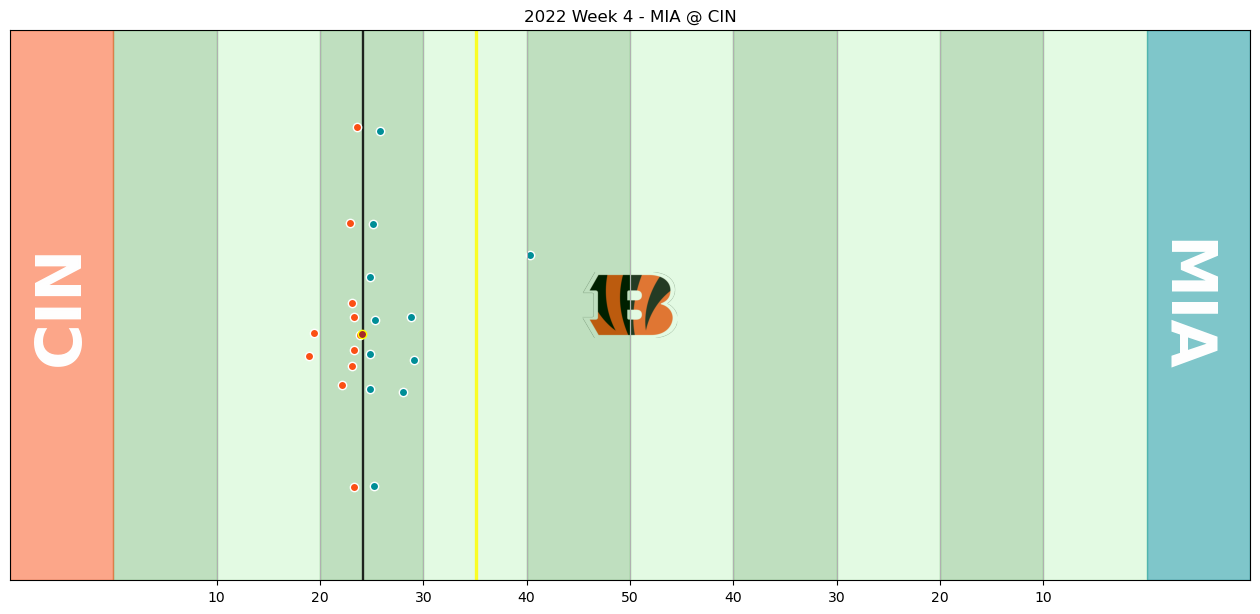

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_49989/4208403530.py:124: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(last_frame[last_frame['club'] == team]['x'], last_frame[last_frame['club'] == team]['y']


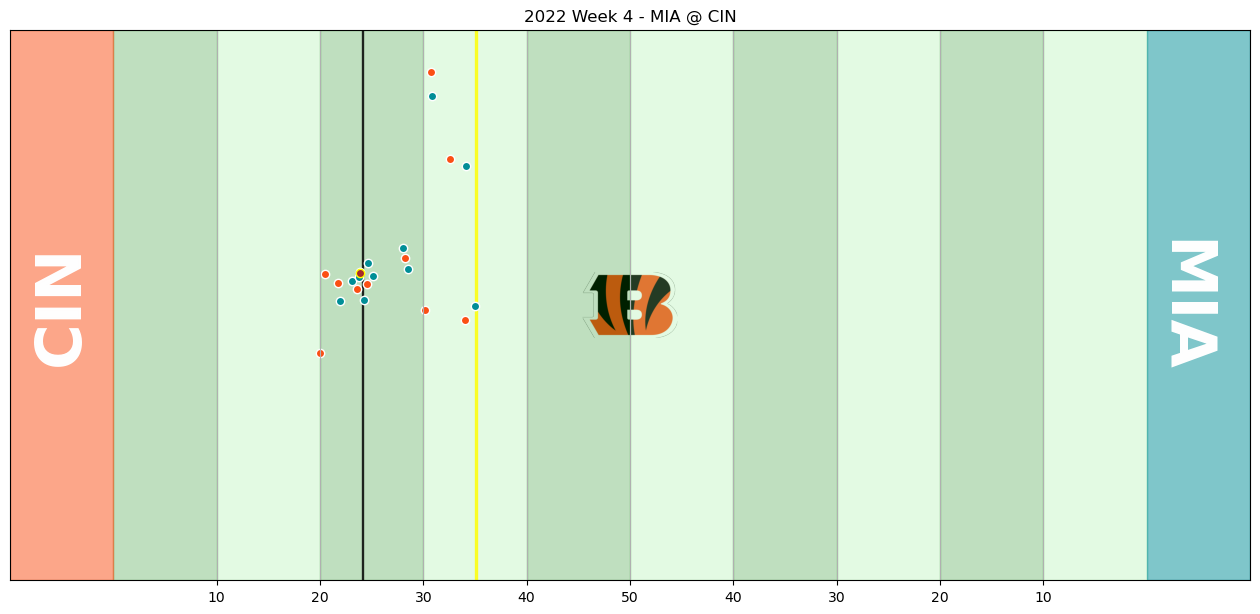

In [277]:
# Build Field and Play formation plot with Matplotlib

# Init figure and title
plt.figure(figsize=(16, 8))
plt.title(f"{game['season']} Week {game['week']} - {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")

# Set x and y scales
plt.xlim(0, 120)  # Adjust the limits according to your data
plt.ylim(0, 53.3)  # Adjust the limits according to your data

# Create vertical bands of green and lightgreen for the field
for i in range(10, 101, 20):    
    plt.axvspan(i, i+10, color='green', alpha=0.25)
    plt.axvspan(i+10, i+20, color='lightgreen', alpha=0.25)

# Hide y-axis labels
plt.yticks(ticks=[], labels=[])

# Yard line labels
plt.xticks(ticks=[20,30,40,50,60,70,80,90,100],
           labels=['10','20','30','40','50','40','30','20','10'])

# Determine play orientation - which team is to the right
x_max = max(play_frame['x'])
max_team = play_frame.loc[(play_frame['x'] == x_max)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(max_team, xy=[113.5, 26.65], xytext=[113.5, 26.65], fontsize=45, 
            fontweight='bold',color='white', rotation=270,ha='center', va='center')
plt.axvspan(110, 120, color=colors[max_team], alpha=0.5)

# Determine play orientation - team to the left
x_min = min(play_frame['x'])
min_team = play_frame.loc[(play_frame['x'] == x_min)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(min_team, xy=[5,26.65], xytext=[5,26.65], fontsize=45, fontweight='bold',
             color='white', rotation=90,ha='center', va='center')
plt.axvspan(0, 10, color=colors[min_team], alpha=0.5)

# Plot home team logo at 50 yard line
plt.imshow(home_img, extent=[55,65,21.65,31.65])

# Determine x Position for First Down marker
if play_frame.iloc[2]['playDirection'] == 'right':
    first_down = play_frame.iloc[22]['x'] + play['yardsToGo']
else:
    first_down = play_frame.iloc[22]['x'] - play['yardsToGo']

# Plot first down and line of scrimmage markers
plt.axvspan(first_down-0.125, first_down+0.125, color='yellow', alpha=0.75)
plt.axvspan(play_frame.iloc[22]['x']-0.05, play_frame.iloc[22]['x']+0.05, color='black', alpha=0.75)

# Scatter plot for player and football positions
for team, color in colors.items():
    if team == 'football':
        edge = 'yellow'
    else:
        edge = 'white'
    plt.scatter(play_frame[play_frame['club'] == team]['x'], play_frame[play_frame['club'] == team]['y']
                ,c=color, label=team, alpha=1, edgecolor=edge)

# Show plot
plt.grid(True, axis='x')
plt.show()

# Init figure and title
plt.figure(figsize=(16, 8))
plt.title(f"{game['season']} Week {game['week']} - {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")

# Set x and y scales
plt.xlim(0, 120)  # Adjust the limits according to your data
plt.ylim(0, 53.3)  # Adjust the limits according to your data

# Create vertical bands of green and lightgreen for the field
for i in range(10, 101, 20):    
    plt.axvspan(i, i+10, color='green', alpha=0.25)
    plt.axvspan(i+10, i+20, color='lightgreen', alpha=0.25)

# Hide y-axis labels
plt.yticks(ticks=[], labels=[])

# Yard line labels
plt.xticks(ticks=[20,30,40,50,60,70,80,90,100],
           labels=['10','20','30','40','50','40','30','20','10'])

# Determine play orientation - which team is to the right
x_max = max(play_frame['x'])
max_team = play_frame.loc[(play_frame['x'] == x_max)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(max_team, xy=[113.5, 26.65], xytext=[113.5, 26.65], fontsize=45, 
            fontweight='bold',color='white', rotation=270,ha='center', va='center')
plt.axvspan(110, 120, color=colors[max_team], alpha=0.5)

# Determine play orientation - team to the left
x_min = min(play_frame['x'])
min_team = play_frame.loc[(play_frame['x'] == x_min)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(min_team, xy=[5,26.65], xytext=[5,26.65], fontsize=45, fontweight='bold',
             color='white', rotation=90,ha='center', va='center')
plt.axvspan(0, 10, color=colors[min_team], alpha=0.5)

# Plot home team logo at 50 yard line
plt.imshow(home_img, extent=[55,65,21.65,31.65])

# Determine x Position for First Down marker
if play_frame.iloc[2]['playDirection'] == 'right':
    first_down = play_frame.iloc[22]['x'] + play['yardsToGo']
else:
    first_down = play_frame.iloc[22]['x'] - play['yardsToGo']

# Plot first down and line of scrimmage markers
plt.axvspan(first_down-0.125, first_down+0.125, color='yellow', alpha=0.75)
plt.axvspan(play_frame.iloc[22]['x']-0.05, play_frame.iloc[22]['x']+0.05, color='black', alpha=0.75)

# Scatter plot for player and football positions
for team, color in colors.items():
    if team == 'football':
        edge = 'yellow'
    else:
        edge = 'white'
    plt.scatter(last_frame[last_frame['club'] == team]['x'], last_frame[last_frame['club'] == team]['y']
                ,c=color, label=team, alpha=1, edgecolor=edge)

# Show plot
plt.grid(True, axis='x')
plt.show()



In [278]:
all_22_plays_df.columns

Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'play_uuid'],
      dtype='object')

In [279]:
all_22_plays_df['playResult'].unique()

array([  3,   7,   9,   6,   0,   2,   8,  -1,  -4,   5,   1,  48,  -2,
        26,  21,  31,  24,  19,   4, -10,  15,  -3,  10,  -7,  11,  23,
        14,  17,  -5,  16,  50,  12,  -6,  13,  -8,  18,  25,  20,  63,
       -59,  45,  30,  51,  53,  38,  34,  44, -15,  35,  28,  27,  22,
        33, -45, -20,  36,  75,  62,  -9,  57,  68,  67,  60,  40, -19,
        41,  58,  43,  46,  29, -26,  37,  32, -14,  39,  49,  54,  56,
        79,  74,  61, -21,  52,  42,  71])

In [280]:
all_22_plays_df['converted'] = (all_22_plays_df['playResult'] > all_22_plays_df['yardsToGo'])
all_22_plays_df['converted'].value_counts()

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_49989/1170212969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_22_plays_df['converted'] = (all_22_plays_df['playResult'] > all_22_plays_df['yardsToGo'])


converted
False    5041
True     1286
Name: count, dtype: int64

In [281]:
third_down_df['converted'] = (third_down_df['playResult'] >= third_down_df['yardsToGo'])
third_down_df.head()

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_49989/1046926644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  third_down_df['converted'] = (third_down_df['playResult'] >= third_down_df['yardsToGo'])


,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,play_uuid,converted
10,2022091112,1994,52470,A.J. Dillon,(13:44) (Shotgun) A.Dillon left tackle to GB 3...,3,3,1,GB,MIN,...,-0.001424,0.001424,1.084807,0.506989,NaN,NaN,NaN,NaN,2022091112.1994,True
13,2022103010,3127,47853,Darrell Henderson,(5:35) (Shotgun) D.Henderson left end to LA 21...,4,3,16,LAR,SF,...,-0.000718,0.000718,-1.245599,-0.218564,NaN,NaN,NaN,NaN,2022103010.3127,False
18,2022103001,1415,44901,D'Onta Foreman,(4:56) (Shotgun) D.Foreman left tackle for 2 y...,2,3,2,CAR,ATL,...,-0.056025,0.056025,5.080226,1.919774,NaN,NaN,NaN,NaN,2022103001.1415,True
30,2022100209,1840,47836,Miles Sanders,(1:15) (Shotgun) M.Sanders up the middle to JA...,2,3,2,PHI,JAX,...,-0.012801,0.012801,4.298187,-1.249802,NaN,NaN,NaN,NaN,2022100209.1840,False
54,2022091901,1683,52461,Jalen Hurts,(2:09) (Shotgun) J.Hurts right end for 26 yard...,2,3,2,PHI,MIN,...,0.046228,-0.046228,3.454048,3.545952,NaN,NaN,NaN,NaN,2022091901.1683,True


In [282]:
frame_conversion_df = third_down_frames_df.merge(third_down_df[['play_uuid', 'converted']], on='play_uuid', how='left')
frame_conversion_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid,converted
0,2022100600,1069,38540.0,Stephon Gilmore,6,2022-10-06 20:58:22.400000,5.0,IND,left,38.44,14.13,0.05,0.05,0.00,37.15,272.30,ball_snap,2022100600.1069,True
1,2022100600,1069,38605.0,Russell Wilson,6,2022-10-06 20:58:22.400000,3.0,DEN,left,45.20,23.77,0.00,0.00,0.01,272.11,354.59,ball_snap,2022100600.1069,True
2,2022100600,1069,38843.0,Rodney McLeod,6,2022-10-06 20:58:22.400000,26.0,IND,left,40.60,18.62,0.01,0.01,0.00,76.12,96.10,ball_snap,2022100600.1069,True
3,2022100600,1069,41369.0,Cameron Fleming,6,2022-10-06 20:58:22.400000,73.0,DEN,left,45.05,26.58,0.56,1.91,0.06,273.86,214.51,ball_snap,2022100600.1069,True
4,2022100600,1069,42358.0,Melvin Gordon,6,2022-10-06 20:58:22.400000,25.0,DEN,left,49.91,23.79,0.11,0.63,0.01,261.38,256.08,ball_snap,2022100600.1069,True


In [283]:
frame_conversion_df.to_csv('data/frame_conversions.csv')

In [284]:
all_22_play_ids

Index(['2022090800.101', '2022090800.1187', '2022090800.1254',
       '2022090800.1385', '2022090800.1406', '2022090800.146',
       '2022090800.1736', '2022090800.191', '2022090800.1946',
       '2022090800.2043',
       ...
       '2022110700.3787', '2022110700.403', '2022110700.443', '2022110700.493',
       '2022110700.546', '2022110700.612', '2022110700.670', '2022110700.80',
       '2022110700.929', '2022110700.950'],
      dtype='object', name='play_uuid', length=6327)

In [285]:
flat_frames_dict = []

for play in all_22_play_ids:
    play_frame = ball_snap_df.loc[(ball_snap_df['play_uuid'] == play)]
    frame_dict = {'play_uuid': play}

    for i in range(23):
        frame_dict['x' + str(i)] = play_frame.iloc[i]['x']
        frame_dict['y' + str(i)] = play_frame.iloc[i]['y']
        frame_dict['s' + str(i)] = play_frame.iloc[i]['s']
        frame_dict['a' + str(i)] = play_frame.iloc[i]['a']
        frame_dict['dis' + str(i)] = play_frame.iloc[i]['dis']
        if i<22:
            frame_dict['o' + str(i)] = play_frame.iloc[i]['o']
            frame_dict['dir' + str(i)] = play_frame.iloc[i]['dir']
    
    flat_frames_dict.append(frame_dict)

transposed_frames_df = pd.DataFrame(flat_frames_dict)


In [244]:
transposed_frames_df

,play_uuid,x0,y0,s0,a0,dis0,o0,dir0,x1,y1,...,s21,a21,dis21,o21,dir21,x22,y22,s22,a22,dis22
0,2022090800.101,73.13,27.67,0.10,1.14,0.02,273.97,348.75,67.35,29.96,...,0.00,0.00,0.00,267.12,339.31,72.040001,29.520000,0.04,0.29,0.01
1,2022090800.1187,71.72,29.54,0.05,0.85,0.01,272.46,55.53,69.25,24.99,...,0.94,0.81,0.09,87.20,10.33,70.070000,29.610001,0.00,0.00,0.01
2,2022090800.1254,59.81,23.63,0.00,0.00,0.00,272.98,143.12,42.18,36.75,...,0.04,0.04,0.02,131.60,216.90,54.689999,23.879999,0.00,0.00,0.00
3,2022090800.1385,36.64,29.50,0.08,0.88,0.01,273.91,130.33,34.44,33.93,...,0.00,0.00,0.03,49.70,91.93,34.990002,29.730000,0.00,0.00,0.00
4,2022090800.1406,18.65,23.35,0.25,1.67,0.02,278.66,52.44,16.13,28.06,...,0.32,0.18,0.03,117.94,100.45,17.389999,23.340000,0.02,0.02,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6322,2022110700.612,73.37,25.06,0.11,0.58,0.01,281.51,254.24,74.11,36.43,...,0.22,0.56,0.02,240.21,321.26,72.830002,29.920000,0.00,0.00,0.00
6323,2022110700.670,82.37,19.86,0.29,1.71,0.02,256.40,302.59,80.80,22.52,...,0.00,0.00,0.04,172.38,162.23,81.779999,23.889999,0.00,0.00,0.00
6324,2022110700.80,69.07,27.04,0.04,0.23,0.01,62.17,44.09,68.68,35.34,...,0.00,0.00,0.00,281.95,290.97,70.260002,29.990000,0.62,3.42,0.07
6325,2022110700.929,76.34,35.18,0.00,0.08,0.00,95.97,142.30,77.70,31.41,...,0.60,0.76,0.05,174.30,226.59,77.029999,29.830000,0.00,0.00,0.01


In [245]:
transposed_frame_conversions_df = transposed_frames_df.merge(all_22_plays_df[['play_uuid','converted']], on='play_uuid', how='left')
transposed_frame_conversions_df.head()

,play_uuid,x0,y0,s0,a0,dis0,o0,dir0,x1,y1,...,a21,dis21,o21,dir21,x22,y22,s22,a22,dis22,converted
0,2022090800.101,73.13,27.67,0.10,1.14,0.02,273.97,348.75,67.35,29.96,...,0.00,0.00,267.12,339.31,72.040001,29.520000,0.04,0.29,0.01,False
1,2022090800.1187,71.72,29.54,0.05,0.85,0.01,272.46,55.53,69.25,24.99,...,0.81,0.09,87.20,10.33,70.070000,29.610001,0.00,0.00,0.01,False
2,2022090800.1254,59.81,23.63,0.00,0.00,0.00,272.98,143.12,42.18,36.75,...,0.04,0.02,131.60,216.90,54.689999,23.879999,0.00,0.00,0.00,False
3,2022090800.1385,36.64,29.50,0.08,0.88,0.01,273.91,130.33,34.44,33.93,...,0.00,0.03,49.70,91.93,34.990002,29.730000,0.00,0.00,0.00,True
4,2022090800.1406,18.65,23.35,0.25,1.67,0.02,278.66,52.44,16.13,28.06,...,0.18,0.03,117.94,100.45,17.389999,23.340000,0.02,0.02,0.00,False


In [246]:
transposed_frame_conversions_df.to_csv('data/transposed_frame_conversions.csv')